In [2]:
# ============================================
# CHARACTER-LEVEL CNN WITH ATTENTION
# PHISHING URL DETECTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
import pickle
import os
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("CHARACTER-LEVEL CNN WITH ATTENTION")
print("PHISHING URL DETECTION")
print("="*60)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

CHARACTER-LEVEL CNN WITH ATTENTION
PHISHING URL DETECTION
Started at: 2025-10-26 16:02:52


In [3]:
# ============================================
# GPU SETUP AND VERIFICATION
# ============================================

print("\n" + "="*60)
print("GPU SETUP")
print("="*60)

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    device = torch.device('cuda')
    print(f"\nUsing GPU for training")
else:
    device = torch.device('cpu')
    print(f"\nWARNING: GPU not available, using CPU")
    print("Training will be much slower!")
    
print(f"Device: {device}")


GPU SETUP

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA GeForce GTX 1650
GPU Memory: 4.00 GB

Using GPU for training
Device: cuda


In [4]:
# ============================================
# LOAD DATA
# ============================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

TRAIN_PATH = '../../../data/processed/url-detection/phishing_features_train.csv'
TEST_PATH = '../../../data/processed/url-detection/phishing_features_test.csv'

print("\nLoading CSV files...")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train: {train_df.shape[0]:,} samples")
print(f"Test: {test_df.shape[0]:,} samples")

# For deep learning, we only need URL and label (not the engineered features)
# Load original URLs from dataset
from datasets import load_dataset

print("\nLoading original URLs from PhreshPhish...")
dataset = load_dataset("phreshphish/phreshphish", cache_dir='E:/.cache/huggingface')

train_urls = [dataset['train'][i]['url'] for i in range(len(dataset['train']))]
test_urls = [dataset['test'][i]['url'] for i in range(len(dataset['test']))]
train_labels = train_df['label'].values
test_labels = test_df['label'].values

print(f"URLs loaded: {len(train_urls):,} train, {len(test_urls):,} test")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)  # benign=0, phish=1
y_test = le.transform(test_labels)

print(f"\nLabel distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")


LOADING DATA

Loading CSV files...
Train: 371,941 samples
Test: 36,787 samples

Loading original URLs from PhreshPhish...
URLs loaded: 371,941 train, 36,787 test

Label distribution (train):
  benign: 253,189 (68.1%)
  phish: 118,752 (31.9%)


In [5]:
# ============================================
# CHARACTER-LEVEL TOKENIZATION
# ============================================

print("\n" + "="*60)
print("CHARACTER TOKENIZATION")
print("="*60)

# Build character vocabulary
all_urls = train_urls + test_urls
all_chars = set(''.join(all_urls))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0  # Padding token
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

vocab_size = len(char_to_idx)
print(f"Vocabulary size: {vocab_size} characters")
print(f"Sample characters: {list(char_to_idx.keys())[:20]}")

# Tokenization function
def tokenize_url(url, char_to_idx, max_length=200):
    tokens = [char_to_idx.get(char, 0) for char in url[:max_length]]
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    return tokens

MAX_URL_LENGTH = 200
print(f"\nMax URL length: {MAX_URL_LENGTH} characters")

# Tokenize all URLs
print("\nTokenizing URLs...")
X_train = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) for url in tqdm(train_urls, desc="Train")])
X_test = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) for url in tqdm(test_urls, desc="Test")])

print(f"\nTokenized shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


CHARACTER TOKENIZATION
Vocabulary size: 225 characters
Sample characters: [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']

Max URL length: 200 characters

Tokenizing URLs...


Test: 100%|██████████| 36787/36787 [00:00<00:00, 170869.71it/s]



Tokenized shapes:
X_train: (371941, 200)
X_test: (36787, 200)


In [6]:
# ============================================
# PYTORCH DATASET CLASS
# ============================================

class URLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = URLDataset(X_train, y_train)
test_dataset = URLDataset(X_test, y_test)

# Calculate class weights for imbalance
n_benign = (y_train == 0).sum()
n_phish = (y_train == 1).sum()
pos_weight = torch.tensor([n_benign / n_phish]).to(device)

print(f"\nClass weight (phishing): {pos_weight.item():.2f}")

# Create dataloaders
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Class weight (phishing): 2.13

Batch size: 256
Train batches: 1453
Test batches: 144


In [7]:
# ============================================
# ATTENTION MECHANISM
# ============================================

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x shape: (batch, seq_len, hidden_dim)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        # attention_weights shape: (batch, seq_len, 1)
        
        # Apply attention
        weighted = x * attention_weights
        # weighted shape: (batch, seq_len, hidden_dim)
        
        return weighted, attention_weights

In [8]:
# ============================================
# CNN ARCHITECTURE
# ============================================

class PhishingCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=256):
        super(PhishingCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multiple parallel convolution layers with different kernel sizes
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        # Additional conv layer
        self.conv_combine = nn.Conv1d(num_filters * 3, 512, kernel_size=3, padding=1)
        
        # Attention mechanism
        self.attention = AttentionLayer(512)
        
        # Dense layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
    
    def forward(self, x):
        # x shape: (batch, seq_len)
        
        # Embedding
        x = self.embedding(x)
        # x shape: (batch, seq_len, embedding_dim)
        
        # Transpose for conv1d (expects channels first)
        x = x.transpose(1, 2)
        # x shape: (batch, embedding_dim, seq_len)
        
        # Parallel convolutions
        conv3_out = self.relu(self.conv3(x))
        conv5_out = self.relu(self.conv5(x))
        conv7_out = self.relu(self.conv7(x))
        
        # Concatenate
        x = torch.cat([conv3_out, conv5_out, conv7_out], dim=1)
        # x shape: (batch, num_filters*3, seq_len)
        
        x = self.dropout(x)
        
        # Additional conv layer
        x = self.relu(self.conv_combine(x))
        # x shape: (batch, 512, seq_len)
        
        # Transpose back for attention
        x = x.transpose(1, 2)
        # x shape: (batch, seq_len, 512)
        
        # Attention mechanism
        x, attention_weights = self.attention(x)
        
        # Global max pooling
        x = torch.max(x, dim=1)[0]
        # x shape: (batch, 512)
        
        # Dense layers
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        # x shape: (batch, 1)
        
        return x.squeeze(), attention_weights

In [9]:
# ============================================
# INITIALIZE MODEL
# ============================================

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

model = PhishingCNN(vocab_size=vocab_size, embedding_dim=128, num_filters=256)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nModel architecture:")
print(model)

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

print(f"\nOptimizer: Adam (lr=0.001)")
print(f"Loss: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")
print(f"Scheduler: ReduceLROnPlateau")


MODEL ARCHITECTURE

Total parameters: 1,866,114
Trainable parameters: 1,866,114

Model architecture:
PhishingCNN(
  (embedding): Embedding(225, 128, padding_idx=0)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv7): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_combine): Conv1d(768, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (attention): AttentionLayer(
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)

Optimizer: Adam (lr=0.001)
Loss: BCEWithLogitsLoss (pos_weight=2.13)
Scheduler: ReduceLROnPlateau


In [10]:
# ============================================
# TRAINING FUNCTIONS
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_X, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, recall

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

In [11]:
# ============================================
# TRAINING LOOP
# ============================================

print("\n" + "="*60)
print("TRAINING")
print("="*60)

NUM_EPOCHS = 10
best_f1 = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_recall': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

print(f"\nTraining for {NUM_EPOCHS} epochs...")
training_start = datetime.now()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc, train_f1, train_recall = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate on test
    val_loss, val_acc, val_prec, val_recall, val_f1, _, _ = evaluate(
        model, test_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, F1: {train_f1*100:.2f}%, Recall: {train_recall*100:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec*100:.2f}%, Recall: {val_recall*100:.2f}%, F1: {val_f1*100:.2f}%")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), '../../../models/url-detection/cnn_best.pth')
        print(f"Best model saved! (F1: {best_f1*100:.2f}%)")

training_end = datetime.now()
training_time = (training_end - training_start).total_seconds()

print(f"\nTraining complete!")
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation F1: {best_f1*100:.2f}%")


TRAINING

Training for 10 epochs...

Epoch 1/10


Train - Loss: 0.2901, Acc: 90.71%, F1: 86.50%, Recall: 93.19%
Val   - Loss: 0.2683, Acc: 92.38%, Prec: 75.12%, Recall: 87.28%, F1: 80.75%
Best model saved! (F1: 80.75%)

Epoch 2/10


Train - Loss: 0.1429, Acc: 96.38%, F1: 94.41%, Recall: 95.71%
Val   - Loss: 0.2070, Acc: 94.01%, Prec: 79.22%, Recall: 91.20%, F1: 84.79%
Best model saved! (F1: 84.79%)

Epoch 3/10


Train - Loss: 0.1091, Acc: 97.23%, F1: 95.71%, Recall: 96.59%
Val   - Loss: 0.2197, Acc: 95.13%, Prec: 85.73%, Recall: 88.10%, F1: 86.90%
Best model saved! (F1: 86.90%)

Epoch 4/10


Train - Loss: 0.0939, Acc: 97.58%, F1: 96.24%, Recall: 97.06%
Val   - Loss: 0.1853, Acc: 95.29%, Prec: 85.10%, Recall: 90.06%, F1: 87.51%
Best model saved! (F1: 87.51%)

Epoch 5/10


Train - Loss: 0.0841, Acc: 97.87%, F1: 96.69%, Recall: 97.39%
Val   - Loss: 0.1973, Acc: 95.43%, Prec: 86.02%, Recall: 89.64%, F1: 87.79%
Best model saved! (F1: 87.79%)

Epoch 6/10


Train - Loss: 0.0769, Acc: 98.04%, F1: 96.95%, Recall: 97.61%
Val   - Loss: 0.1836, Acc: 95.61%, Prec: 86.42%, Recall: 90.21%, F1: 88.27%
Best model saved! (F1: 88.27%)

Epoch 7/10


Train - Loss: 0.0724, Acc: 98.16%, F1: 97.13%, Recall: 97.79%
Val   - Loss: 0.1999, Acc: 95.62%, Prec: 86.67%, Recall: 89.94%, F1: 88.28%
Best model saved! (F1: 88.28%)

Epoch 8/10


Train - Loss: 0.0678, Acc: 98.25%, F1: 97.28%, Recall: 97.95%
Val   - Loss: 0.1986, Acc: 95.57%, Prec: 86.01%, Recall: 90.58%, F1: 88.23%

Epoch 9/10


Train - Loss: 0.0643, Acc: 98.36%, F1: 97.45%, Recall: 98.07%
Val   - Loss: 0.1752, Acc: 95.58%, Prec: 85.08%, Recall: 92.00%, F1: 88.41%
Best model saved! (F1: 88.41%)

Epoch 10/10


Train - Loss: 0.0610, Acc: 98.43%, F1: 97.56%, Recall: 98.17%
Val   - Loss: 0.1836, Acc: 95.88%, Prec: 86.76%, Recall: 91.48%, F1: 89.06%
Best model saved! (F1: 89.06%)

Training complete!
Total training time: 62.88 minutes
Best validation F1: 89.06%


In [12]:
# ============================================
# LOAD BEST MODEL AND FINAL EVALUATION
# ============================================

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load('../../../models/url-detection/cnn_best.pth'))
print("Best model loaded")

# Final evaluation
_, test_acc, test_prec, test_recall, test_f1, y_pred, y_probs = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)

print(f"\nAccuracy:  {test_acc*100:.2f}%")
print(f"Precision: {test_prec*100:.2f}%")
print(f"Recall:    {test_recall*100:.2f}%")
print(f"F1-Score:  {test_f1*100:.2f}%")

# Compare with XGBoost
print("\n" + "="*60)
print("COMPARISON WITH XGBOOST")
print("="*60)

print("\nXGBoost (TF-IDF + Manual):")
print(f"  Accuracy:  95.20%")
print(f"  Precision: 86.25%")
print(f"  Recall:    87.83%")
print(f"  F1-Score:  87.03%")

print(f"\nCNN with Attention:")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  Precision: {test_prec*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1-Score:  {test_f1*100:.2f}%")

print(f"\nImprovement:")
print(f"  Accuracy:  {test_acc*100-95.20:+.2f}%")
print(f"  Precision: {test_prec*100-86.25:+.2f}%")
print(f"  Recall:    {test_recall*100-87.83:+.2f}%")
print(f"  F1-Score:  {test_f1*100-87.03:+.2f}%")


FINAL EVALUATION
Best model loaded



FINAL TEST RESULTS

Accuracy:  95.88%
Precision: 86.76%
Recall:    91.48%
F1-Score:  89.06%

COMPARISON WITH XGBOOST

XGBoost (TF-IDF + Manual):
  Accuracy:  95.20%
  Precision: 86.25%
  Recall:    87.83%
  F1-Score:  87.03%

CNN with Attention:
  Accuracy:  95.88%
  Precision: 86.76%
  Recall:    91.48%
  F1-Score:  89.06%

Improvement:
  Accuracy:  +0.68%
  Precision: +0.51%
  Recall:    +3.65%
  F1-Score:  +2.03%



CONFUSION MATRIX

True Negatives:  29,107
False Positives: 941
False Negatives: 574
True Positives:  6,165

False Positive Rate: 3.13%
False Negative Rate: 8.52%


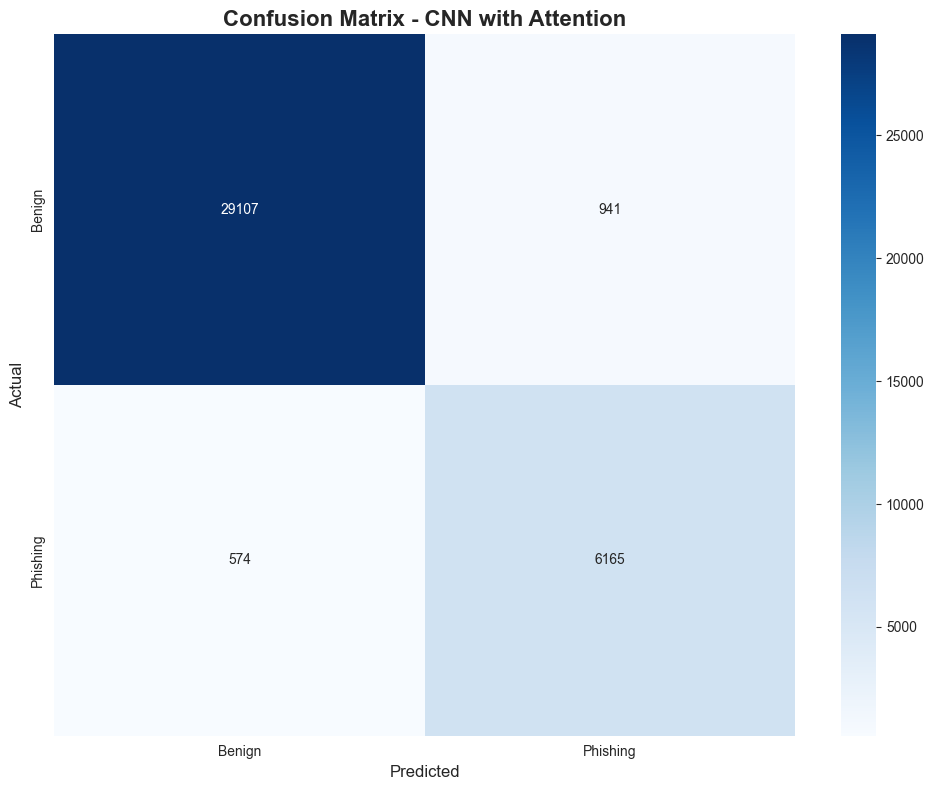

In [13]:
# ============================================
# CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred)

print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

fpr = cm[0,1] / (cm[0,0] + cm[0,1])
fnr = cm[1,0] / (cm[1,0] + cm[1,1])

print(f"\nFalse Positive Rate: {fpr*100:.2f}%")
print(f"False Negative Rate: {fnr*100:.2f}%")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title('Confusion Matrix - CNN with Attention', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


ROC CURVE
ROC AUC: 0.9873


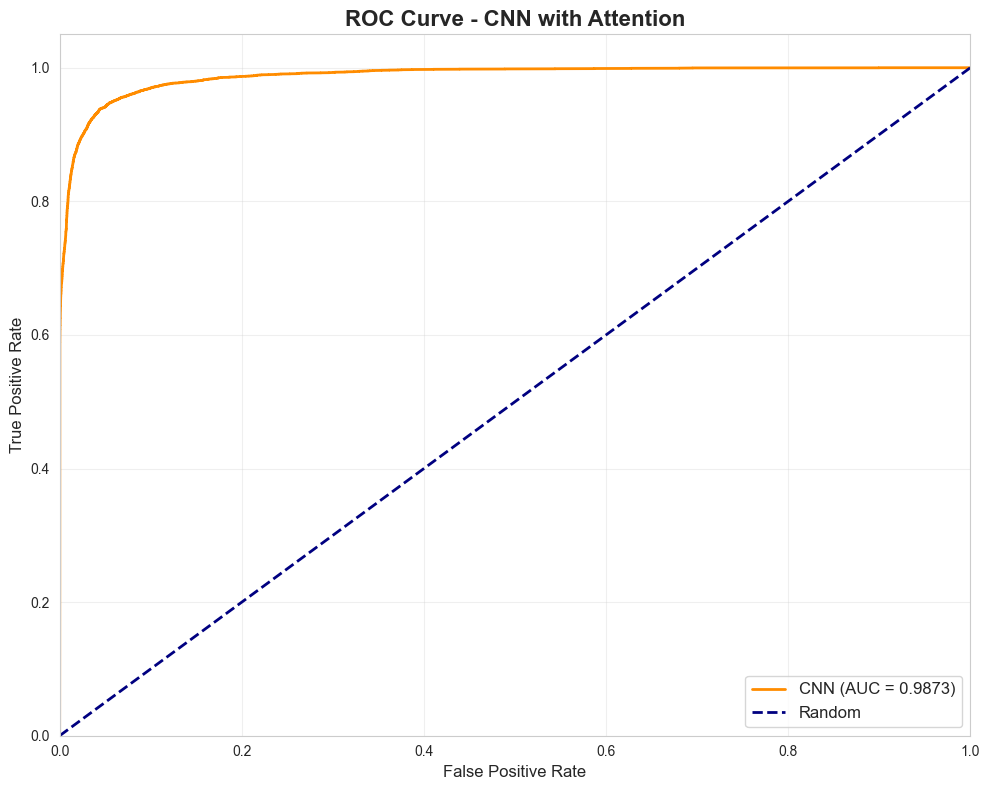

In [14]:
# ============================================
# ROC CURVE
# ============================================

print("\n" + "="*60)
print("ROC CURVE")
print("="*60)

roc_auc = roc_auc_score(y_test, y_probs)
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_probs)

print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
         label=f'CNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CNN with Attention', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TRAINING CURVES


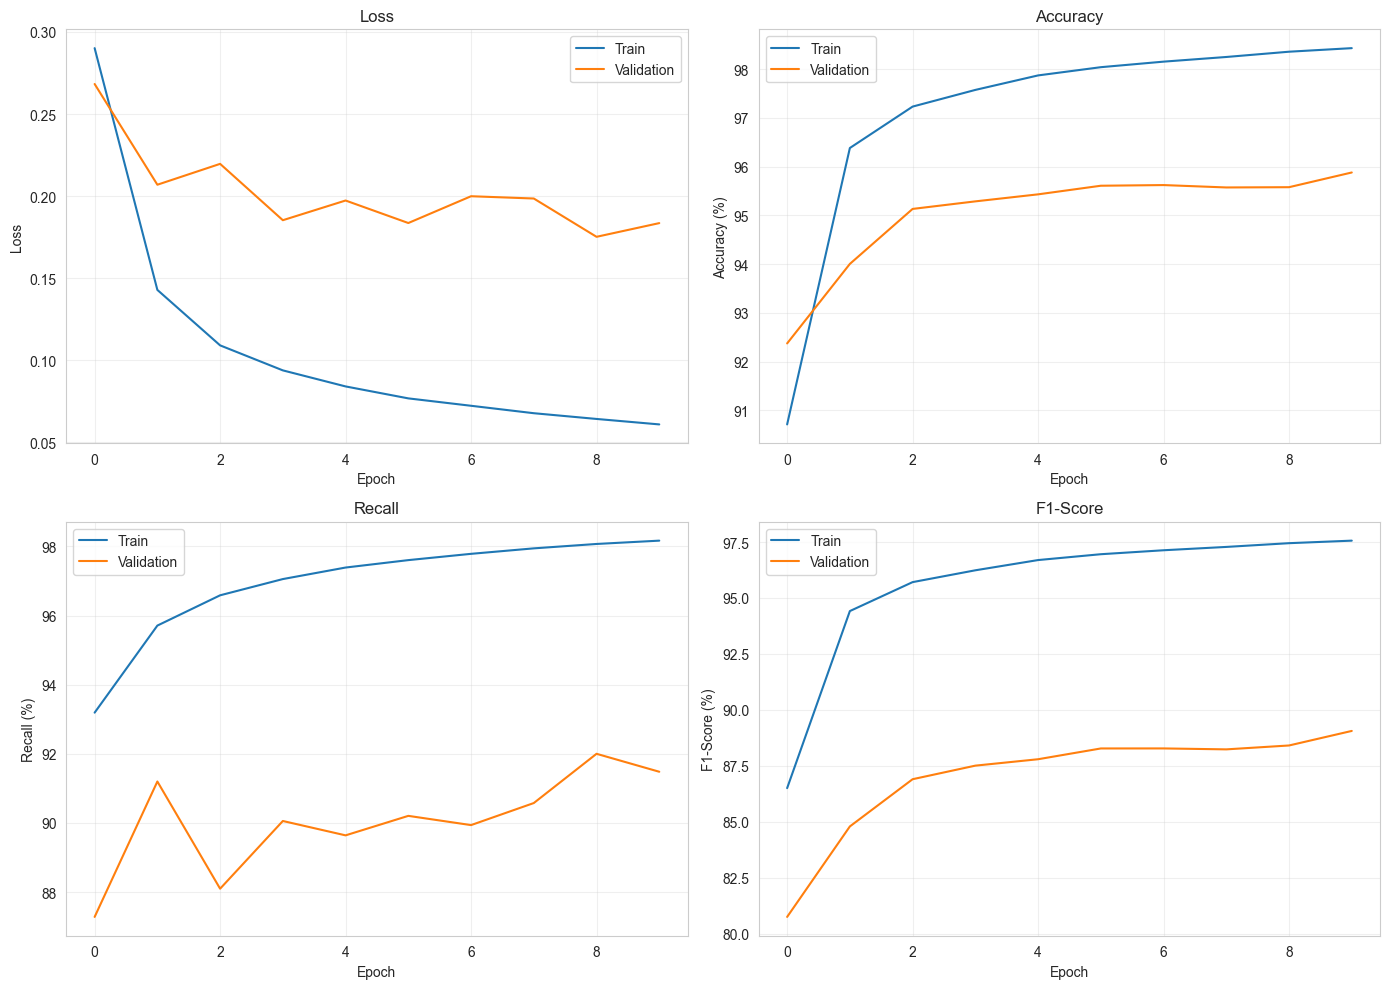

In [15]:
# ============================================
# TRAINING CURVES
# ============================================

print("\n" + "="*60)
print("TRAINING CURVES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot([x*100 for x in history['train_acc']], label='Train')
axes[0, 1].plot([x*100 for x in history['val_acc']], label='Validation')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Recall
axes[1, 0].plot([x*100 for x in history['train_recall']], label='Train')
axes[1, 0].plot([x*100 for x in history['val_recall']], label='Validation')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall (%)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F1-Score
axes[1, 1].plot([x*100 for x in history['train_f1']], label='Train')
axes[1, 1].plot([x*100 for x in history['val_f1']], label='Validation')
axes[1, 1].set_title('F1-Score')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1-Score (%)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Save tokenizer
tokenizer_path = '../../../models/url-detection/char_tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump({'char_to_idx': char_to_idx, 'max_length': MAX_URL_LENGTH}, f)
print(f"Tokenizer saved: {tokenizer_path}")

# Save metrics
metrics = {
    'model': 'CNN with Attention',
    'test_accuracy': float(test_acc),
    'test_precision': float(test_prec),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'training_time_minutes': float(training_time/60),
    'num_epochs': NUM_EPOCHS,
    'best_epoch_f1': float(best_f1),
    'total_params': total_params,
    'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_df = pd.DataFrame([metrics])
metrics_path = '../../../models/url-detection/cnn_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrics saved: {metrics_path}")

Tokenizer saved: ../../../models/url-detection/char_tokenizer.pkl
Metrics saved: ../../../models/url-detection/cnn_metrics.csv
